# Age-Gender Recognition using Facenet and Sklearn models

### Steps

1. Calculate Facenet weights for Audience images
2. Train SVM / KNN models to predict age and gender

### Imports

In [5]:
import os,sys
import importlib
import pandas as pd
import numpy as np
import glob

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [6]:
%load_ext autoreload

%autoreload 2

In [7]:
project_dir = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))
if not project_dir in sys.path: sys.path.append(project_dir)

In [8]:
facenet = importlib.import_module('src.facenet_embeddings', project_dir)
adience = importlib.import_module('src.adience.adience_utils', project_dir)
plot = importlib.import_module('src.rgutils.plot', project_dir)
utils = importlib.import_module('src.utils', project_dir)

### Image data

In [9]:
DATA_DIR = '../data/external/adience/faces/'
labels_dir = '../data/external/adience/'
num_folds = 5

##### Load and explore labels

In [10]:
indices = list(range(num_folds))
labels = adience.load_labels(labels_dir, indices)

In [11]:
labels.shape

(19370, 7)

In [12]:
labels.sample(4)

,user_id,original_image,face_id,age,gender,tilt_ang,fold
1120,20632896@N03,9824101165_03bc6ba16b_o.jpg,570,"(15, 20)",f,-95,1
3214,68825596@N05,11594296434_bd9419dbc7_o.jpg,290,"(15, 20)",f,-100,0
1010,7890646@N03,10195441525_109279b5aa_o.jpg,1392,"(38, 42)",m,0,3
3257,68825596@N05,11594178496_ebb154cb6f_o.jpg,290,"(15, 20)",f,-80,0


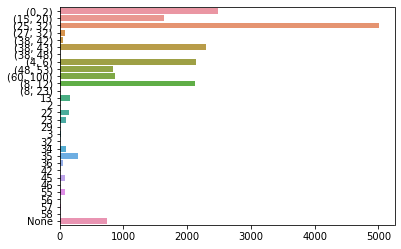

In [13]:
age_groups, age_cnts = np.unique(labels['age'], return_counts=True)

sns.barplot(x=age_cnts, y=age_groups, order=age_groups);

In [14]:
labels['gender'].value_counts(True)

f    0.504115
m    0.436770
u    0.059115
Name: gender, dtype: float64

In [15]:
pd.crosstab(labels['age'], labels['gender'])

gender,f,m,u
age,,,
"(0, 2)",681,716,1091
"(15, 20)",907,733,2
"(25, 32)",2672,2279,2
"(27, 32)",77,0,0
"(38, 42)",0,46,0
"(38, 43)",1052,1241,0
"(38, 48)",0,6,0
"(4, 6)",1230,909,1
"(48, 53)",421,404,0


##### Filter out noizy labels

In [16]:
target_ages = ['(0, 2)', '(4, 6)', '(8, 12)', '(15, 20)', '(25, 32)', 
               '(38, 43)', '(48, 53)', '(60, 100)']
target_genders = ['f', 'm']

In [17]:
labels_clean = labels.loc[(labels['age'].isin(target_ages)) &
                          (labels['gender'].isin(target_genders))]

labels_clean.shape

(16228, 7)

##### Get image paths

In [18]:
image_paths = [adience.get_image_path(row, DATA_DIR)[0] for _,row in labels_clean.iterrows()]
lmk_paths = [adience.get_image_path(row, DATA_DIR)[1] for _,row in labels_clean.iterrows()]

len(image_paths), len(lmk_paths)

(16228, 16228)

### Crop out images

In [19]:
crop_dir = '../data/interim/adience/crops'

In [20]:
utils.create_dir(crop_dir, True)

In [21]:
cropped_images = adience.facial_keypoints(image_paths, lmk_paths, 
                                          crop=True, keypoints=False, save_dir=crop_dir)

3985it [01:29, 45.06it/s]/home/neuro/.local/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: ../data/interim/adience/crops/coarse_tilt_aligned_face.490.12086568994_7de441924a_o.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
4033it [01:30, 52.21it/s]/home/neuro/.local/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: ../data/interim/adience/crops/coarse_tilt_aligned_face.490.12101177803_594c1e5040_o.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
4071it [01:31, 54.19it/s]/home/neuro/.local/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: ../data/interim/adience/crops/coarse_tilt_aligned_face.490.12101687086_2fe8fd2c4b_o.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
4092it [01:31, 53.38it/s]/home/neuro/.local/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: ../data/interim/adience/crops/coarse_tilt_aligned_face.490.12101302143_b467a2080d_o.jpg is a low 

### Facenet embeddings

In [140]:
model_path = '../models/20180402-114759/20180402-114759.pb'
image_size = 160
batch_size = 256

In [142]:
embeddings = facenet.compute_embeddings(model_path, image_paths, batch_size, image_size)

Model filename: ../models/20180402-114759/20180402-114759.pb


Batch inference: 100%|██████████| 64/64 [02:37<00:00,  1.88s/it]

Mean inference time 0.0013, batch size 256


In [153]:
max_path_len = max(list(map(len, image_paths)))

paths = np.array(image_paths, dtype=f'|S{max_path_len}')

In [155]:
save_embeddings = '../data/interim/adience/embeddings/facenet_embeddings_cropped.hdf'

utils.create_hdf(save_embeddings, {'embeddings': embeddings,
                                   'image_paths': paths},)

In [156]:
embeddings.shape

(16228, 512)

##### Visualize distances

In [157]:
from sklearn.metrics import pairwise

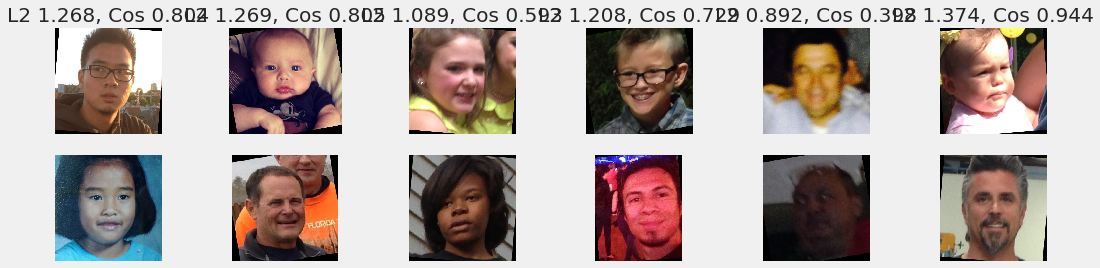

In [158]:
n_show = 6

fig,ax = plt.subplots(2, n_show, sharex=False, sharey=False, figsize=(16,4))
sns.set_style('white')
_ = [a.axis('off') for a in ax.ravel()]

for n in range(n_show):
    i = np.random.randint(len(image_paths))
    j = np.random.randint(len(image_paths))
    i_img = plt.imread(image_paths[i])
    j_img = plt.imread(image_paths[j])
    ax[0,n].imshow(i_img)
    ax[1,n].imshow(j_img)
    l2_ = np.linalg.norm(embeddings[i] - embeddings[j], ord=2)
    cos_ = pairwise.cosine_distances(embeddings[i][np.newaxis,...], 
                                    embeddings[j][np.newaxis,...]).squeeze()
    ax[0,n].set_title(f'L2 {l2_:.3f}, Cos {cos_:.3f}')

plt.subplots_adjust(wspace=0.5)
plt.show()

##### Investigate matches

In [159]:
subset_start = 10000
subset_size = 300

In [168]:
embeddings_s1 = embeddings[subset_start: subset_start + subset_size]
embeddings_s2 = embeddings[subset_start + subset_size: subset_start + subset_size*2]

img_paths_s1 = image_paths[subset_start: subset_start + subset_size]
img_paths_s2 = image_paths[subset_start + subset_size: subset_start + subset_size*2]

In [169]:
l2 = pairwise.euclidean_distances(embeddings_s1, embeddings_s2)
cos = pairwise.cosine_distances(embeddings_s1, embeddings_s2)

l2.shape, cos.shape

((300, 300), (300, 300))

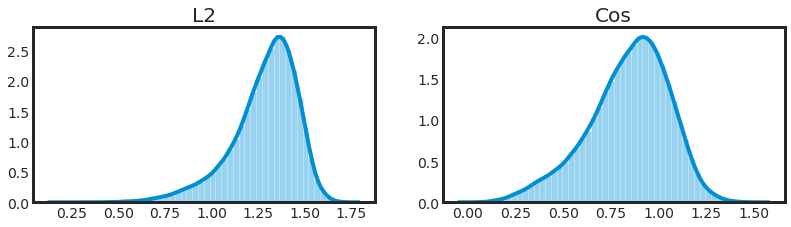

In [170]:
plot.histograms({'L2': l2.ravel(), 'Cos': cos.ravel()}, 1, 2, fig_dims=(12,3))

###### by l2

In [171]:
l2_threshold = 0.8

In [172]:
matches = np.argwhere(l2 < l2_threshold)

l2.shape, matches.shape

((300, 300), (1495, 2))

In [174]:
a = axes[0,c]

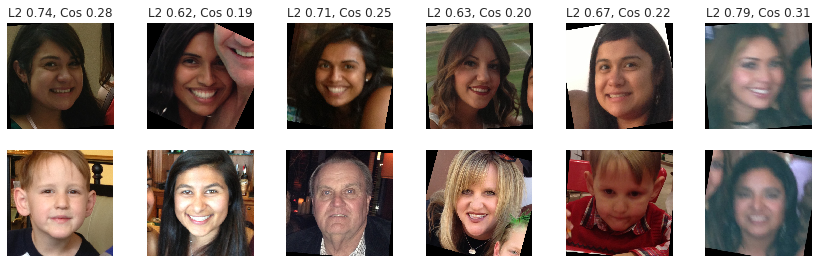

In [175]:
n_row,n_col = 2, 6
fig,axes = plt.subplots(n_row, n_col, squeeze=False, figsize=(n_col*2 + 1, n_row*2))
_ = [ax.axis('off') for ax in axes.ravel()]

for c in range(n_col):
    i,j = matches[np.random.randint(0, len(matches))]
    i_img = plt.imread(img_paths_s1[i])
    j_img = plt.imread(img_paths_s2[j])
    axes[0, c].imshow(i_img)
    axes[1, c].imshow(j_img)
    axes[0, c].set_title(f'L2 {l2[i,j]:.2f}, Cos {cos[i,j]:.2f}', fontsize=12)
plt.show()

### Build ml models

In [104]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

from tqdm import tqdm


In [107]:
ml = importlib.import_module('src.rgutils.ml', project_dir)


In [108]:
def cross_validated_learning(model, features, folds, labels, metric_fn):
    '''
    Cross-validate thru given folds and measure mean and std metric
    '''
    k_folds = list(np.unique(folds))
    train_scores,val_scores = [],[]
    for fold in k_folds:
        print('='*10, 'Fold', fold, '='*10)
        mask = folds == fold
        X_train,y_train = features[~mask],labels[~mask]
        X_val,y_val = features[mask],labels[mask]
        print(f'Sizes: train {len(y_train)}, validation {len(y_val)}')
        model.fit(X_train, y_train)
        train_pred = model.predict(X_train)
        val_pred = model.predict(X_val)
        train_score = metric_fn(y_train, train_pred)
        val_score = metric_fn(y_val, val_pred)
        print(f'Scores: train {train_score:.3f}, validation {val_score:.4f}')
        train_scores.append(train_score), val_scores.append(val_score)
    print(f'Mean train score: {np.mean(train_scores):.3f} +- {np.std(train_scores):.4f}')
    print(f'Mean validation score: {np.mean(val_scores):.3f} +- {np.std(val_scores):.4f}')
    return model,train_scores,val_scores

In [109]:
age = labels_clean['age']
gender = labels_clean['gender']

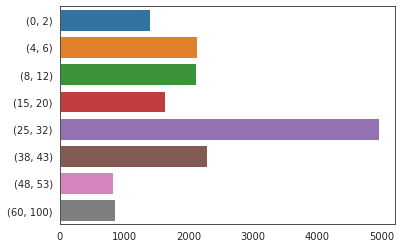

In [110]:
age_groups, age_cnts = np.unique(age, return_counts=True)

sns.barplot(x=age_cnts, y=age_groups, order=target_ages);

In [111]:
gender.value_counts(True)

f    0.528161
m    0.471839
Name: gender, dtype: float64

In [112]:
pd.crosstab(age, gender)

gender,f,m
age,,
"(0, 2)",681,716
"(15, 20)",907,733
"(25, 32)",2672,2279
"(38, 43)",1052,1241
"(4, 6)",1230,909
"(48, 53)",421,404
"(60, 100)",420,446
"(8, 12)",1188,929


##### PCA features

In [113]:
from sklearn.decomposition import PCA

In [114]:
pca = PCA(n_components=45)

pca, embeddings_pca = ml.reduce_dimensions(pca, embeddings)

print(f'Explained variance: {pca.explained_variance_ratio_.sum():.3f}')

Explained variance: 0.983


In [115]:
embeddings_pca.shape

(16228, 45)

##### Age models

In [116]:
knn = KNeighborsClassifier(n_neighbors=9, n_jobs=-1)

knn,train_scores,val_scores = cross_validated_learning(knn, embeddings, labels_clean['fold'],
                                                       age, accuracy_score)

========== Fold 0 ==========
Sizes: train 12288, validation 3940
Scores: train 0.610, validation 0.3619
========== Fold 1 ==========
Sizes: train 13232, validation 2996
Scores: train 0.626, validation 0.2730
========== Fold 2 ==========
Sizes: train 13160, validation 3068
Scores: train 0.616, validation 0.3243
========== Fold 3 ==========
Sizes: train 13374, validation 2854
Scores: train 0.609, validation 0.3238
========== Fold 4 ==========
Sizes: train 12858, validation 3370
Scores: train 0.618, validation 0.3024
Mean train score: 0.616 +- 0.0060
Mean validation score: 0.317 +- 0.0292


In [117]:
lgbm = LGBMClassifier(max_depth=5, n_jobs=-1)

lgbm,train_scores,val_scores = cross_validated_learning(lgbm, embeddings, labels_clean['fold'],
                                                        age, accuracy_score)

========== Fold 0 ==========
Sizes: train 12288, validation 3940
Scores: train 0.835, validation 0.4419
========== Fold 1 ==========
Sizes: train 13232, validation 2996
Scores: train 0.796, validation 0.3064
========== Fold 2 ==========
Sizes: train 13160, validation 3068
Scores: train 0.797, validation 0.3713
========== Fold 3 ==========
Sizes: train 13374, validation 2854
Scores: train 0.807, validation 0.3812
========== Fold 4 ==========
Sizes: train 12858, validation 3370
Scores: train 0.809, validation 0.3721
Mean train score: 0.809 +- 0.0140
Mean validation score: 0.375 +- 0.0430


In [118]:
logreg = LogisticRegression(n_jobs=-1)

logreg,train_scores,val_scores = cross_validated_learning(logreg, embeddings, labels_clean['fold'],
                                                        age, accuracy_score)

========== Fold 0 ==========
Sizes: train 12288, validation 3940


/home/neuro/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/neuro/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/neuro/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Scores: train 0.421, validation 0.4297
========== Fold 1 ==========
Sizes: train 13232, validation 2996


/home/neuro/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/neuro/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/neuro/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Scores: train 0.466, validation 0.3097
========== Fold 2 ==========
Sizes: train 13160, validation 3068


/home/neuro/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/neuro/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/neuro/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Scores: train 0.447, validation 0.3553
========== Fold 3 ==========
Sizes: train 13374, validation 2854


/home/neuro/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/neuro/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/neuro/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Scores: train 0.441, validation 0.3833
========== Fold 4 ==========
Sizes: train 12858, validation 3370


/home/neuro/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/neuro/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/neuro/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Scores: train 0.453, validation 0.3570
Mean train score: 0.445 +- 0.0147
Mean validation score: 0.367 +- 0.0393


##### Gender model

In [119]:
knn = KNeighborsClassifier(n_jobs=-1)

knn,train_scores,val_scores = cross_validated_learning(knn, embeddings_pca, labels_clean['fold'], 
                                                       gender, accuracy_score)

========== Fold 0 ==========
Sizes: train 12288, validation 3940
Scores: train 0.841, validation 0.6482
========== Fold 1 ==========
Sizes: train 13232, validation 2996
Scores: train 0.833, validation 0.6482
========== Fold 2 ==========
Sizes: train 13160, validation 3068
Scores: train 0.830, validation 0.6626
========== Fold 3 ==========
Sizes: train 13374, validation 2854
Scores: train 0.827, validation 0.6482
========== Fold 4 ==========
Sizes: train 12858, validation 3370
Scores: train 0.839, validation 0.6448
Mean train score: 0.834 +- 0.0055
Mean validation score: 0.650 +- 0.0063


In [120]:
lgbm = LGBMClassifier(max_depth=5, n_jobs=-1)

lgbm,train_scores,val_scores = cross_validated_learning(lgbm, embeddings_pca, labels_clean['fold'],
                                                        gender, accuracy_score)

========== Fold 0 ==========
Sizes: train 12288, validation 3940
Scores: train 0.840, validation 0.6777
========== Fold 1 ==========
Sizes: train 13232, validation 2996
Scores: train 0.831, validation 0.6969
========== Fold 2 ==========
Sizes: train 13160, validation 3068
Scores: train 0.837, validation 0.6675
========== Fold 3 ==========
Sizes: train 13374, validation 2854
Scores: train 0.830, validation 0.6766
========== Fold 4 ==========
Sizes: train 12858, validation 3370
Scores: train 0.835, validation 0.6712
Mean train score: 0.835 +- 0.0037
Mean validation score: 0.678 +- 0.0102


### Build up fully connected layers

In [121]:
import keras

from keras import layers, optimizers, metrics, models, callbacks

Using TensorFlow backend.


In [130]:
def cross_validated_learning(features, folds, labels,
                             num_classes, eta, batch_size, max_epochs,
                             train_callbacks,):
    '''
    Cross-validate thru given folds and measure mean and std metric
    '''
    k_folds = list(np.unique(folds))
    histories = {}
    models = {}
    for fold in k_folds:
        print('='*10, 'Fold', fold, '='*10)
        val_mask = folds == fold
        X_train,y_train = features[~val_mask],labels[~val_mask]
        X_val,y_val = features[val_mask],labels[val_mask]
        print(f'Train {len(y_train)}, validation {len(y_val)}')
        model = get_model(num_classes, eta)
        hist = model.fit(x=X_train, y=y_train,
                         batch_size=batch_size, epochs=max_epochs,
                         validation_data=(X_val, y_val), 
                         callbacks=train_callbacks,
                         verbose=0,
                        )
        epochs_stop = len(hist.history['loss'])
        print(f'Best validation accuracy {max(hist.history["val_acc"]):.3f}',
              f'@ {epochs_stop} epochs')
        hist.history['epoch'] = list(range(epochs_stop))
        hist.history['train_loss'] = hist.history['loss']
        hist.history['train_accuracy'] = hist.history['acc']
        hist.history['val_accuracy'] = hist.history['val_acc']
        histories[fold] = hist.history
        models[fold] = model
    val_scores = [max(v['val_accuracy']) for k,v in histories.items()]
    print('='*30)
    print(f'Cross-fold validation accuracy {np.mean(val_scores):.3f} +- {np.std(val_scores):.4f}')
    return models, histories

def get_model(num_classes, eta):
    # build model
    model = models.Sequential()
    model.add(layers.Dense(512,input_shape=(input_size,)))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.5))
    if num_classes == 2:
        out_activation = 'sigmoid'
        loss_type = 'binary_crossentropy'
    else:
        out_activation = 'softmax'
        loss_type = 'categorical_crossentropy'
    model.add(layers.Dense(num_classes, activation=out_activation))
    # compile this model
    optim = optimizers.Adam(eta)
    model.compile(optim, loss=loss_type, metrics=['accuracy'])
    return model

##### Age models

In [123]:
age_encoder = set(age)
age_encoder = {a:i for i,a in enumerate(age_encoder)}
age_decoder = {a:i for i,a in age_encoder.items()}

print(age_encoder)
print(age_decoder)

{'(0, 2)': 0, '(48, 53)': 1, '(15, 20)': 2, '(38, 43)': 3, '(60, 100)': 4, '(4, 6)': 5, '(25, 32)': 6, '(8, 12)': 7}
{0: '(0, 2)', 1: '(48, 53)', 2: '(15, 20)', 3: '(38, 43)', 4: '(60, 100)', 5: '(4, 6)', 6: '(25, 32)', 7: '(8, 12)'}


In [124]:
age_encoded = age.map(age_encoder)
age_encoded = keras.utils.to_categorical(age_encoded)

In [126]:
training_callbacks = [
    callbacks.EarlyStopping('val_acc', min_delta=1e-4, patience=30, restore_best_weights=True),
    callbacks.ReduceLROnPlateau('val_acc', factor=0.5, patience=20, verbose=1, min_delta=1e-4),
    ]

In [127]:
input_size = embeddings.shape[1]
num_classes = len(age_encoder)

eta = 0.0002
num_epochs = 200
batch_size = 128

In [128]:
trained_models,hist = cross_validated_learning(embeddings, labels_clean['fold'], age_encoded, 
                         num_classes, eta, batch_size, num_epochs, training_callbacks,
                        )

W0802 14:52:18.043675 140208212494144 deprecation_wrapper.py:119] From /home/neuro/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0802 14:52:18.068014 140208212494144 deprecation.py:506] From /home/neuro/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0802 14:52:18.139987 140208212494144 deprecation_wrapper.py:119] From /home/neuro/.local/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



========== Fold 0 ==========
Train 12288, validation 3940


W0802 14:52:18.250608 140208212494144 deprecation.py:323] From /home/neuro/.local/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 00032: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
Best validation accuracy 0.464 @ 42 epochs
========== Fold 1 ==========
Train 13232, validation 2996

Epoch 00084: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
Best validation accuracy 0.339 @ 94 epochs
========== Fold 2 ==========
Train 13160, validation 3068

Epoch 00084: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
Best validation accuracy 0.404 @ 94 epochs
========== Fold 3 ==========
Train 13374, validation 2854

Epoch 00036: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
Best validation accuracy 0.416 @ 46 epochs
========== Fold 4 ==========
Train 12858, validation 3370

Epoch 00057: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
Best validation accuracy 0.398 @ 67 epochs
Cross-fold validation accuracy 0.404 +- 0.0399


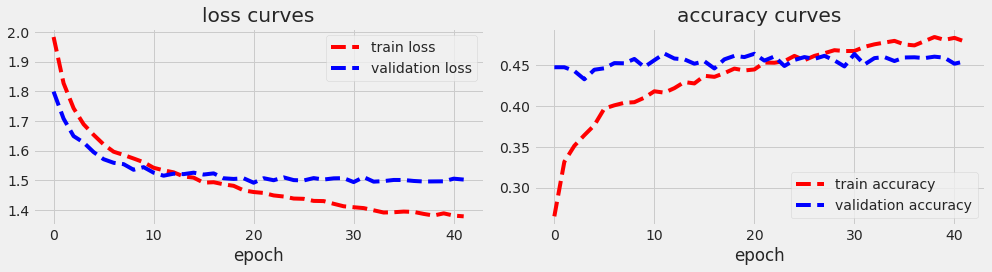

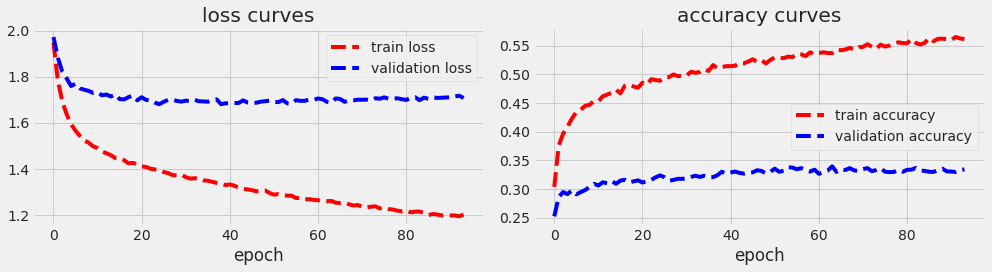

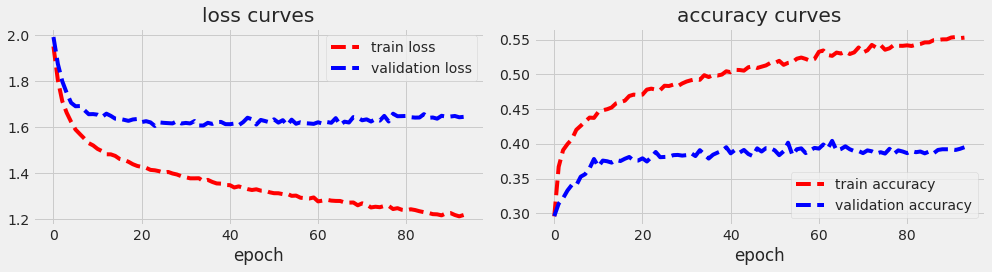

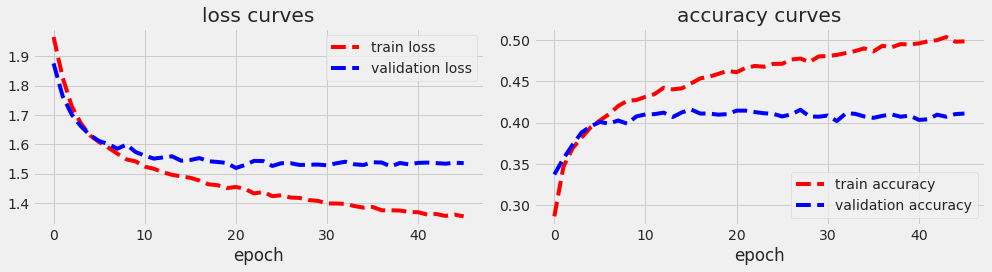

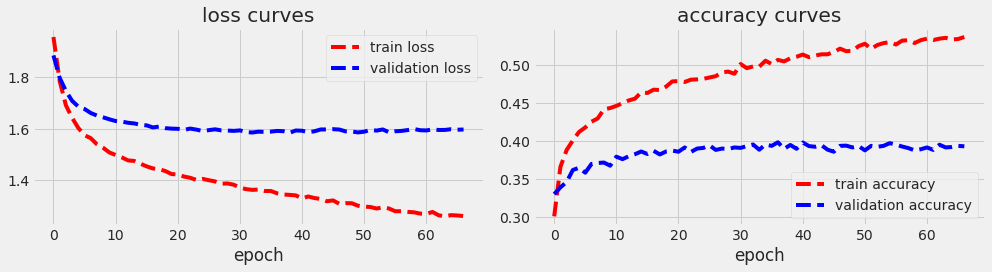

In [129]:
for i in range(num_folds):
    plot.plot_learning_curve(hist[i], fig_shape=(14,4))

##### Gender models

In [131]:
gender_encoder = set(gender)
gender_encoder = {a:i for i,a in enumerate(gender_encoder)}
gender_decoder = {a:i for i,a in gender_encoder.items()}

print(gender_encoder)
print(gender_decoder)

{'m': 0, 'f': 1}
{0: 'm', 1: 'f'}


In [132]:
gender_encoded = gender.map(gender_encoder)
gender_encoded = keras.utils.to_categorical(gender_encoded)

In [133]:
training_callbacks = [
    callbacks.EarlyStopping('val_acc', min_delta=1e-4, patience=30, restore_best_weights=True),
    callbacks.ReduceLROnPlateau('val_acc', factor=0.5, patience=20, verbose=1, min_delta=1e-4),
    ]

In [137]:
input_size = embeddings.shape[1]
num_classes = len(gender_encoder)

eta = 0.00005
num_epochs = 200
batch_size = 128

In [138]:
trained_models,hist = cross_validated_learning(embeddings, labels_clean['fold'], gender_encoded, 
                         num_classes, eta, batch_size, num_epochs, training_callbacks,
                        )

========== Fold 0 ==========
Train 12288, validation 3940

Epoch 00062: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
Best validation accuracy 0.698 @ 72 epochs
========== Fold 1 ==========
Train 13232, validation 2996

Epoch 00056: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
Best validation accuracy 0.717 @ 66 epochs
========== Fold 2 ==========
Train 13160, validation 3068

Epoch 00084: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
Best validation accuracy 0.682 @ 94 epochs
========== Fold 3 ==========
Train 13374, validation 2854

Epoch 00091: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00121: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
Best validation accuracy 0.699 @ 131 epochs
========== Fold 4 ==========
Train 12858, validation 3370

Epoch 00055: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
Best validation accuracy 0.693 @ 65 epochs
Cross-fo

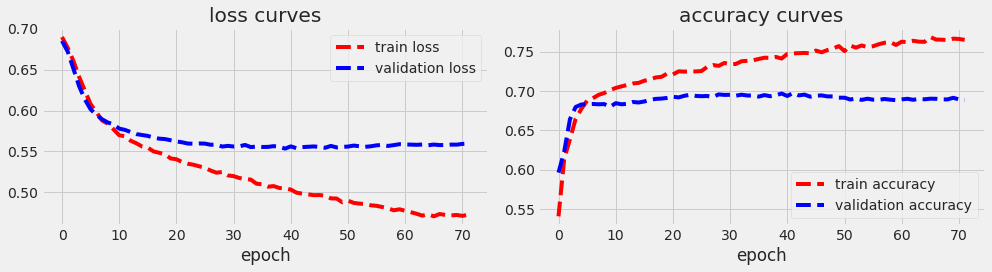

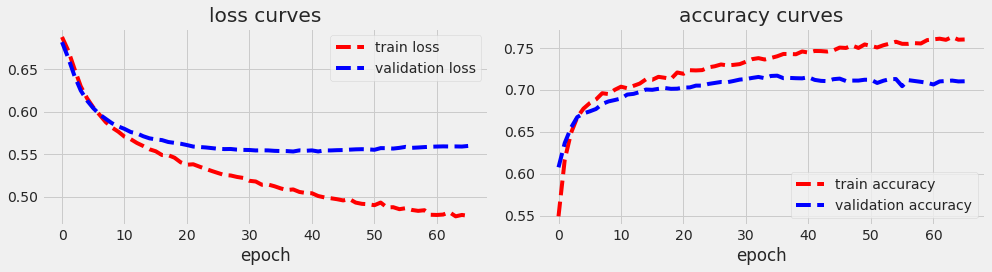

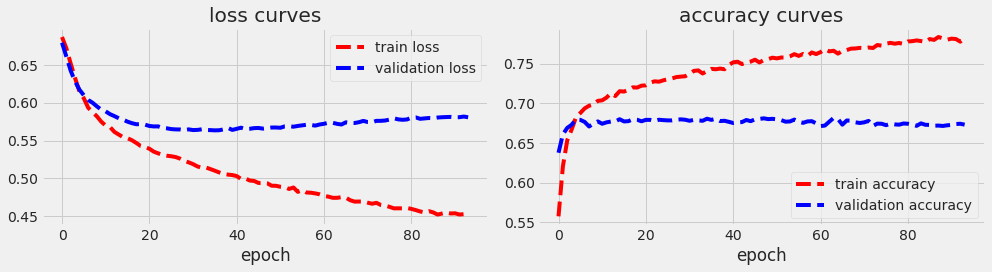

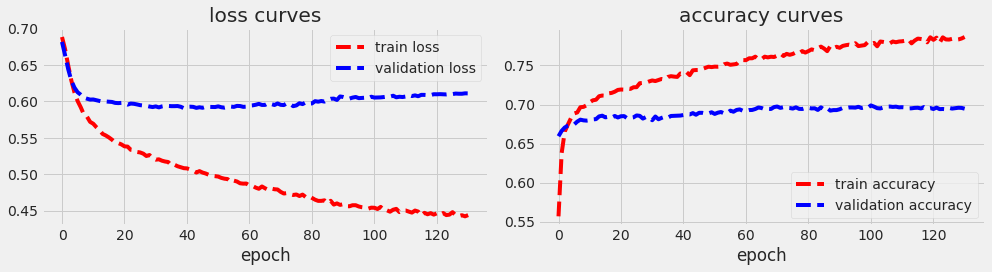

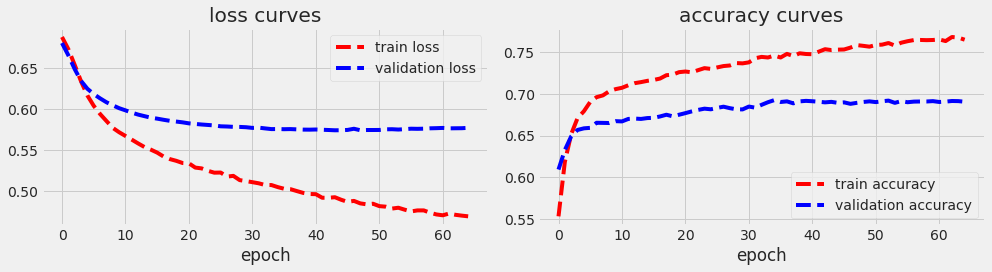

In [139]:
for i in range(num_folds):
    plot.plot_learning_curve(hist[i], fig_shape=(14,4))